# HW3: Multi-class Classification and Neural Networks

In this exercise, we will implement a one-vs-all logistic regression and neural networks to recognize hand-written digits.    

#### Notebook setup

In [1]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.misc
import scipy.optimize as op
import random
from IPython.display import display, Math, Latex
import os
os.chdir('%s/courses/coursera_ml008/hw3' % os.getenv('DST'))
print(os.getcwd())

# plotting options
%matplotlib inline
np.set_printoptions(precision=4, linewidth=120)
plt.rc('font'  , size=18)
plt.rc('figure', figsize=(10, 8))
plt.rc('axes'  , labelsize=22)
plt.rc('legend', fontsize=16)

np.set_printoptions(precision=4)
plt.rc('figure', figsize=(10, 8))

C:\Users\J28976\Documents\Development\dst\courses\coursera_ml008\hw3


#### tex setup
$ \newcommand{\prob}{\mathbb{P}} $

## Multi-class Classification

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9).  In this part of the exercise, you will extend logistic regression and apply it to one-vs-all classification. 

#### load the data

In [2]:
import scipy.io
data = scipy.io.loadmat('ex3data1.mat')
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X = data['X']
y = data['y']
X.shape, y.shape

((5000L, 400L), (5000L, 1L))

There are 5000 Training examples in the file, where each training example is a 20x20 pixel of grayscale intensity at that location.  The 20x20 grid is "unrolled" into a 400 dimensional vector.  Each of the training examples becomes a single row in our data matrix ${\bf X}$.  This gives us a 5000 by 400 matrix.

\begin{align}
{\bf X} = 
\left( 
\begin{array}{c}
-\ {{\bf x}^{(1)} }^T - \\
-\ {{\bf x}^{(2)} }^T - \\
\vdots  \\
-\ {{\bf x}^{(m)} }^T - \\
\end{array} 
\right)
\end{align}

The second part of the training set is a 5000-dimensional vector ${\bf y}$ that contains labels for the training set.  To make things easier in Octave/Matlab, the "0" digit is represented by "10".  Let us remap this since we are using python.

In [4]:
y = np.where(y==10, 0, y)
y[0:5]

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=uint8)

### visualize the data

In [5]:
# m is # training set, n is the number of features (pixels)
m, n = X.shape
m, n

(5000L, 400L)

In [6]:
image = np.zeros((10*20, 10*20))
random.seed(1)
for i in np.arange(100):
    row       = i/10
    col       = i%10
    row_begin = row*20
    row_end   = (row+1)*20
    col_begin = col*20
    col_end   = (col+1)*20
    idx       = random.uniform(0,5000)
    image[row_begin:row_end,:][:,col_begin:col_end] = X[idx].reshape(20,20)

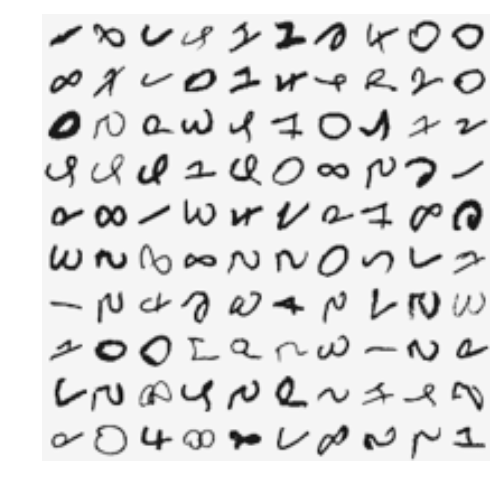

In [7]:
plt.imshow(image, cmap='Greys')
plt.axis('off')
plt.show()

## Vectorize Logistic Regressions

We will be using a mutiple one-vs-all logistic regression model to build a multi-class classifer.  Since there are 10 classes, we need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized.  In this section, you will implement a vectorized version of logistic regression that does not emply any **for** loops.

### vectorized cost function

First write a vectorized version of the cost function.  Recall that the unregularized logistic regression has a cost function of

\begin{align}
    J(\theta) &= \frac{1}{m} \sum_{i=1}^{m} \left[-y^{(i)}\log\left\{h_{\theta}(x^{(i)})\right\} - (1 - y^{(i)})\log\left\{1 - h_{\theta}(x^{(i)})\right\} \right]
\end{align}

To compute each element in the summation, we have to compute $h_{\theta}(x^{(i)})$ for every sample $i$, where $h_{\theta}(x^{(i)}) = g({\bf \theta}^T x^{(i)})$ and $g(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function.  It turns out that we can compute this quickly for all our examples by using matrix multiplication where a row represent a element in the training set and a column represents a feature.  As before, define

\begin{align}
{\bf X} = 
\left( 
\begin{array}{c}
-\ {{\bf x}^{(1)} }^T - \\
-\ {{\bf x}^{(2)} }^T - \\
\vdots  \\
-\ {{\bf x}^{(m)} }^T - \\
\end{array} 
\right)
\end{align}

and 

\begin{align}
{\bf \theta} = 
\left( 
\begin{array}{ccc}
\theta_0 & \dots & \theta_n \\
\end{array} 
\right) \\
\end{align}

Thus, we can compute the product:


\begin{align}
\left( 
\begin{array}{ccc}
x_0^{(1)} & \dots  & x_n^{(1)} \\
x_0^{(2)} & \dots  & x_n^{(2)} \\
          & \vdots &           \\
x_0^{(m)} & \dots  & x_n^{(m)} \\
\end{array}
\right)
\left( 
\begin{array}{ccc}
\theta_0 & \dots & \theta_n \\
\end{array} 
\right)^T
&= \left( 
\begin{array}{ccc}
x_0^{(1)} & \dots  & x_n^{(1)} \\
x_0^{(2)} & \dots  & x_n^{(2)} \\
          & \vdots &           \\
x_0^{(m)} & \dots  & x_n^{(m)} \\
\end{array}
\right)
\left( 
\begin{array}{c}
\theta_0\\
\theta_1\\
\vdots \\
\theta_n\\
\end{array}
\right)
&= {\bf X}\ {\bf \theta}^T
\end{align}

#### logistic function

In [8]:
def g(z):
    return 1.0/(1 + np.exp(-z))

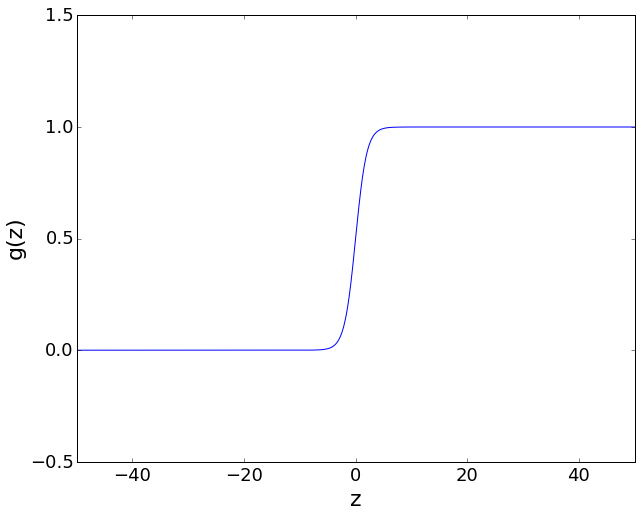

In [9]:
z = np.linspace(-50,50, 1000)
plt.plot(z, g(z))
plt.axis([-50, 50, -0.5, 1.5])
plt.xlabel("z")
plt.ylabel("g(z)")

#### hypothesis function

In [10]:
def h(theta, X):
    X     = np.asmatrix(X)
    theta = np.asmatrix(theta)
    return g(X*theta.T)

### vectorized gradient

Recall that the gradient of the unregularized regression cost is a vector where the $j^{th}$ elemtn is defined as:

\begin{align}
    \frac{\partial J}{\partial \theta_f} 
    &= \frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{f}^{(i)} \\
\end{align}

To vectorize this operation over the dataset, we start by writing out all partial derivatives:

\begin{align}
\left[ 
\begin{array}{c}
    \frac{\partial J}{\partial \theta_0} \\ 
    \frac{\partial J}{\partial \theta_1} \\ 
    \frac{\partial J}{\partial \theta_2} \\ 
    \vdots                               \\ 
    \frac{\partial J}{\partial \theta_n} \\ 
\end{array}
\right]
&= \frac{1}{m}
\left[
\begin{array}{c}
     \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{0}^{(i)} \\
     \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{1}^{(i)} \\
     \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{2}^{(i)} \\
     \vdots \\
     \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{n}^{(i)} \\
\end{array}
\right] \\
&= \frac{1}{m}\sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) {\bf x^{(i)}} \\
&= \frac{1}{m} {\bf X}^T\left( h_{\theta}(x) - y \right) \\
\end{align}

where

\begin{align}
\left( h_{\theta}(x) - y \right) =
\left[
\begin{array}{c}
     h_{\theta}({\bf x}^{(1)}) - y^{(1)} \\
     h_{\theta}({\bf x}^{(2)}) - y^{(2)} \\
     h_{\theta}({\bf x}^{(3)}) - y^{(3)} \\
     \vdots \\
     h_{\theta}({\bf x}^{(m)}) - y^{(m)} \\
\end{array}
\right]
\end{align}

Note that ${\bf x}^{(i)}$ is a vector in feature space, while $\left(h_{\theta}({\bf x}^{(i)}) - y^{(i)}\right)$ is a scalar. To understand the last step of the derivation, let $\beta_i = \left(h_{\theta}({\bf x}^{(i)}) - y^{(i)}\right)$ and observe that:

\begin{align}
\sum_i \beta_i {\bf x}^{(i)} = 
\left[
\begin{array}{ccc}
| & | & & | \\
{\bf x}^{(1)} & {\bf x}^{(2)} & \dots &  {\bf x}^{(m)} \\
| & | & & | \\
\end{array}
\right]
\left[
\begin{array}{c}
\beta_1 \\
\beta_2 \\
\vdots  \\
\beta_m \\
\end{array}
\right]
= {\bf X}^T{\bf \beta}
\end{align}







### Regularization

Now implement the cost function and gradient for the regularized logistic regression.  Recall that a quadratic term in $\theta_j$ is used to "penalize" features -- almost like a damping term in the gradient descent.  The cost function becomes:

\begin{align}
    J(\theta) &= \frac{1}{m} \sum_{i=1}^{m} \left[-y^{(i)}\log\left\{h_{\theta}(x^{(i)})\right\} - (1 - y^{(i)})\log\left\{1 - h_{\theta}(x^{(i)})\right\} \right] + \frac{\lambda}{2m}\sum_{f=1}^{n}\theta_f^2
\end{align}

and the gradient is now:

\begin{align}
\begin{array}{cc}
    \frac{\partial}{\partial \theta_0} J(\theta)
    = \frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{f}^{(i)} & {\text,\ for\ }f = 0 \\
    \frac{\partial}{\partial \theta_f} J(\theta)
    = \frac{1}{m} \sum_{i=1}^{m} \left( h_{\theta}({\bf x}^{(i)}) - y^{(i)} \right) x_{f}^{(i)} + \frac{\lambda}{m}\theta_j & {\text,\ for\ }f \neq 0 \\
\end{array}
\end{align}

#### cost function (regulated)

In [11]:
def cost(theta, X, y, lambda_param=0.0):  
    m, n  = X.shape # m = # training, n = # of features + 1
    X     = np.asmatrix(X)
    y     = np.asmatrix(y)
    theta = np.asmatrix(theta)
    beta  = h(theta, X) - y
    #print(X.shape, y.shape, theta.shape, beta.shape, beta.T.shape)
    
    assert(X.shape[0]==y.shape[0])
    assert(y.shape[1]==1)
    assert(theta.shape==(1,n))
    
    h_value = h(theta, X)
    h_value = np.where(np.isclose(h_value, 1.0), 0.9999999, h_value)
    h_value = np.where(np.isclose(h_value,   0), 0.0000001, h_value)
  
    result  = (1.0/m)*np.sum(-y.T*np.log(h_value) - (1-y).T*np.log(1-h_value))
    result += (lambda_param/(2*m))*np.sum(np.power(theta[1:],2)) # regularization
    return result

#### gradient function (regulated)

In [21]:
def grad(theta, X, y, lambda_param=0.0):
    m, n  = X.shape # m = # training, n = # of features + 1
    X     = np.asmatrix(X)
    y     = np.asmatrix(y)
    theta = np.asmatrix(theta)
    beta  = h(theta, X) - y
    #print(X.shape, y.shape, theta.shape, beta.shape, beta.T.shape)
    
    assert(X.shape[0]==y.shape[0])
    assert(y.shape[1]==1)
    assert(theta.shape==(1,n))
        
    reg    = (lambda_param/float(m))*np.concatenate((np.zeros_like(theta[:,0]),theta[:,1:]), axis=1)
    result = (1.0/m)*beta.T*X + reg
    result = np.asarray(result).reshape(n)
    return result

### Compute One vs. All Classifier

In [22]:
# parameters
lambda_param = 0.0
num_labels   = 10 # number of classification labels (0-9)
c            = 7  # current character to match
y_vec        = np.matrix(y==c, dtype=np.int)
y_vec.shape

(5000L, 1L)

In [23]:
# reset the data
X = data['X']
y = data['y']
y = np.where(y==10, 0, y)
X.shape, y.shape

((5000L, 400L), (5000L, 1L))

In [24]:
# local variables (m --> # training, n --> # of features)
m, n = X.shape
m, n

(5000L, 400L)

In [25]:
# add ones to the X data matrix
X = np.concatenate((np.ones((m,1)), X), axis=1)
X.shape

(5000L, 401L)

In [26]:
theta0 = np.asmatrix(np.zeros((1, n+1)))
# theta0 = np.asmatrix(np.random.rand(1, n+1))
theta0.shape

(1L, 401L)

#### check it

In [27]:
cost(theta0, X, y, lambda_param=0.0), grad(theta0, X, y, lambda_param=0.0).shape

(-17.051420641774779, (401L,))

In [28]:
grad_wrap = lambda theta : grad(theta, X, y, 0.00)
cost_wrap = lambda theta : cost(theta, X, y, 0.00)
op.check_grad(cost_wrap, grad_wrap, theta0)

225339.4023198573

#### optimize

In [29]:
op_result = op.minimize(fun=cost, x0=theta0, args=(X, y, lambda_param), method='SLSQP', options={'maxiter': 50, 'disp':True})
op_result

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3641.07778742
            Iterations: 2
            Function evaluations: 811
            Gradient evaluations: 2


  status: 0
 success: True
    njev: 2
    nfev: 811
     fun: -3641.0777874214859
       x: array([ -7.5805e+00,   0.0000e+00,   0.0000e+00,  -7.2767e-07,   1.0475e-05,   2.4842e-05,  -1.0454e-03,  -1.2321e-03,
        -5.8763e-04,  -1.7402e-04,  -4.0331e-04,  -1.2799e-04,   9.7483e-05,   2.1088e-04,   3.7353e-04,   5.8701e-04,
         4.2460e-04,   1.2337e-04,   8.2921e-07,  -1.3369e-06,   0.0000e+00,  -3.8922e-07,   3.5453e-06,   6.5998e-06,
         1.1805e-04,   3.2977e-04,  -1.4774e-03,  -5.2141e-03,  -7.7694e-03,  -6.3309e-03,  -2.4829e-03,   2.7449e-04,
         8.1847e-04,   5.2313e-04,   7.4510e-04,  -6.1608e-04,  -6.5035e-04,   2.7155e-04,   4.7672e-04,   7.0424e-05,
         1.5527e-05,   3.7653e-06,  -3.9430e-05,   1.7722e-04,  -1.1349e-03,  -7.5363e-03,  -2.5284e-02,  -4.3378e-02,
        -4.9225e-02,  -3.8242e-02,  -2.0992e-02,  -1.5419e-02,  -1.4541e-02,  -3.0415e-02,  -6.8488e-02,  -8.7435e-02,
        -5.3778e-02,  -1.7246e-02,  -4.8421e-03,   1.8964e-04,  -5.3958e-0

In [30]:
# op_result = op.minimize(fun=cost, jac=grad, x0=theta0, args=(X, y, lambda_param), method='SLSQP', options={'maxiter': 50, 'disp':True})
# op_result

In [57]:
theta_fit = np.asmatrix(op_result.x)
theta_fit.shape

(1L, 401L)

In [61]:
p = h(theta_fit, X)
p.shape, p

((5000L, 1L), matrix([[  2.2517e-67],
         [  3.0466e-73],
         [  3.5509e-92],
         ..., 
         [  1.6390e-43],
         [  4.2196e-85],
         [  1.7872e-68]]))

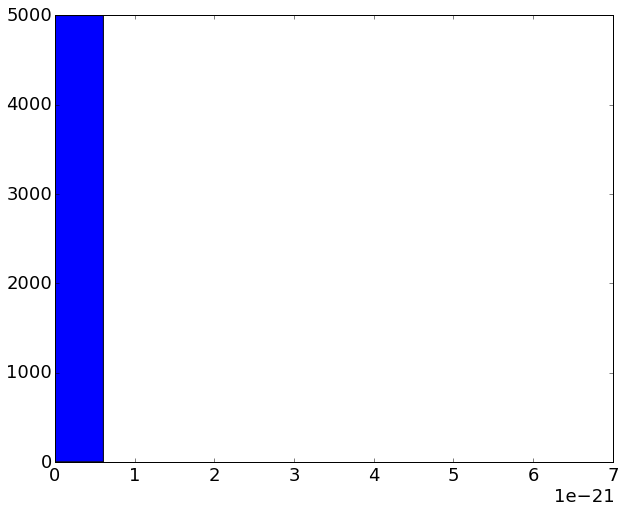

In [65]:
plt.hist(p)
plt.show()

In [67]:
pred = (p > 0.50)
pred.shape

(5000L, 1L)

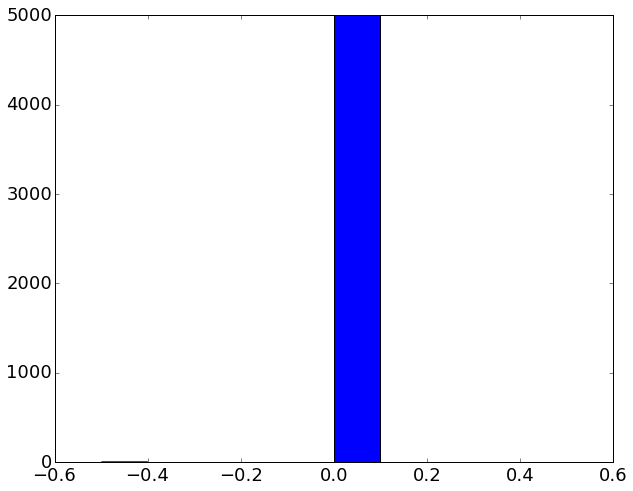

In [68]:
plt.hist(pred)
plt.show()

In [51]:
np.sum(result)

0

(array([  500.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,  4500.]),
 array([   0. ,   25.5,   51. ,   76.5,  102. ,  127.5,  153. ,  178.5,  204. ,  229.5,  255. ]),
 <a list of 10 Patch objects>)

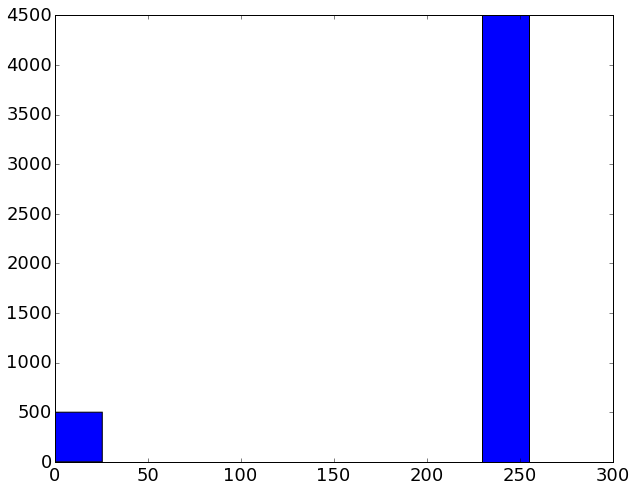

In [70]:
plt.hist(pred - y)